# Testing the model

In this notebook, I will test my best trained model on the data that it has never seen before to see if it is quite good in practice. 
Data can be found <a href="https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis"> here </a>

I will conduct the same data preprocessing steps as in the twitter sentiment analysis notebook to prepare it for the following model predicting. In this notebook, I consider that any data visualization plots are not significant for the testing and evaluation my model, with the exception of the confusion matrix plot and ROC-AUC curve.  

In [1]:
# utilities
import pandas as pd
import stopwords
import string
import joblib
import sys

# nltk
from nltk.tokenize import RegexpTokenizer
import nltk

In [2]:
sys.path.append('../scripts')

In [3]:
# importing the necessary functions for data preprocessing and model evaluation

from preprocessing_data import remove_stopwords, remove_punctuations, remove_URLs, remove_numbers, stemming, lemmatizing
from evaluate_model import evaluate_model

In [4]:
# importing the dataset

DATASET_COLUMNS=['ids', 'entity', 'target', 'text']
csv_path = "../data/twitter_validation.csv"

df = pd.read_csv(csv_path, names=DATASET_COLUMNS)
df.head()

,ids,entity,target,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [5]:
# replacing the values for the easier understanding

df.loc[df['target'] == 'Positive', 'target'] = 1
df.loc[df['target'] == 'Negative', 'target'] = 0

In [6]:
# getting rid of twits that has neutral either irrelevant sentiment

df = df[~df['target'].isin(['Neutral', 'Irrelevant'])]

In [7]:
df['target'].unique()

array([0, 1], dtype=object)

In [8]:
# selecting target and text columns for the further analysis

data = df[['target','text']]
data.head()

,target,text
2,0,@Microsoft Why do I pay for WORD when it funct...
3,0,"CSGO matchmaking is so full of closet hacking,..."
5,0,Hi @EAHelp I’ve had Madeleine McCann in my cel...
6,1,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
7,1,"Rocket League, Sea of Thieves or Rainbow Six: ..."


In [9]:
# dropping null twits from the dataset

data = data.dropna()

In [10]:
# converting statement texts into lower case

# data = data.copy()
data['text'] = data['text'].str.lower()

In [11]:
# cleaning and removing all the stopwords from the tweets

stopwords_list = stopwords.get_stopwords("english")

data['text'] = data['text'].apply(lambda text: remove_stopwords(text, stopwords_list))
data.head()

,target,text
2,0,@microsoft pay word functions poorly @samsungu...
3,0,"csgo matchmaking full closet hacking, truly aw..."
5,0,hi @eahelp i’ve madeleine mccann cellar past 1...
6,1,thank @eamaddennfl!! new te austin hooper oran...
7,1,"rocket league, sea thieves rainbow six: siege🤔..."


In [12]:
# cleaning and removing all the punctuations

english_punctuations = string.punctuation
print(english_punctuations)

data['text'] = data['text'].apply(lambda text: remove_punctuations(text, english_punctuations))
data.head()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,target,text
2,0,microsoft pay word functions poorly samsungus ...
3,0,csgo matchmaking full closet hacking truly awf...
5,0,hi eahelp i’ve madeleine mccann cellar past 13...
6,1,thank eamaddennfl new te austin hooper orange ...
7,1,rocket league sea thieves rainbow six siege🤔 l...


In [13]:
# cleaning and removing all the URLs

data['text'] = data['text'].apply(lambda text: remove_URLs(text))
data.head()

,target,text
2,0,microsoft pay word functions poorly samsungus ...
3,0,csgo matchmaking full closet hacking truly awf...
5,0,hi eahelp i’ve madeleine mccann cellar past 13...
6,1,thank eamaddennfl new te austin hooper orange ...
7,1,rocket league sea thieves rainbow six siege🤔 l...


In [14]:
# cleaning and removing all the numbers

data['text'] = data['text'].apply(remove_numbers)
data.head()

,target,text
2,0,microsoft pay word functions poorly samsungus ...
3,0,csgo matchmaking full closet hacking truly awf...
5,0,hi eahelp i’ve madeleine mccann cellar past ...
6,1,thank eamaddennfl new te austin hooper orange ...
7,1,rocket league sea thieves rainbow six siege🤔 l...


In [15]:
# getting tokenization of the tweet texts

tokenizer = RegexpTokenizer(r'\w+')

data['text'] = data['text'].apply(tokenizer.tokenize)
data.head()

,target,text
2,0,"[microsoft, pay, word, functions, poorly, sams..."
3,0,"[csgo, matchmaking, full, closet, hacking, tru..."
5,0,"[hi, eahelp, i, ve, madeleine, mccann, cellar,..."
6,1,"[thank, eamaddennfl, new, te, austin, hooper, ..."
7,1,"[rocket, league, sea, thieves, rainbow, six, s..."


In [16]:
# applying stemming 

st = nltk.PorterStemmer()

data['text'] = data['text'].apply(lambda text: stemming(text, st))
data.head()

,target,text
2,0,"[microsoft, pay, word, functions, poorly, sams..."
3,0,"[csgo, matchmaking, full, closet, hacking, tru..."
5,0,"[hi, eahelp, i, ve, madeleine, mccann, cellar,..."
6,1,"[thank, eamaddennfl, new, te, austin, hooper, ..."
7,1,"[rocket, league, sea, thieves, rainbow, six, s..."


In [17]:
# applying lemmatizer

lm = nltk.WordNetLemmatizer()

data['text'] = data['text'].apply(lambda text: lemmatizing(text, lm))
data.head()

,target,text
2,0,"[microsoft, pay, word, functions, poorly, sams..."
3,0,"[csgo, matchmaking, full, closet, hacking, tru..."
5,0,"[hi, eahelp, i, ve, madeleine, mccann, cellar,..."
6,1,"[thank, eamaddennfl, new, te, austin, hooper, ..."
7,1,"[rocket, league, sea, thieves, rainbow, six, s..."


In [18]:
# separating input features and labels

Xdata = data['text'].astype(str)
ydata = data['target'].astype(int)

In [19]:
# transforming the subdatasets using the fitted before TF-IDF Vectorizer

vectorizer = joblib.load('../vectorizer/fitted_vectorizer.pkl')

Xdata = vectorizer.transform(Xdata)

In [20]:
# loading the trained before model

model = joblib.load('../models/twitter_logistic_model.pkl')

              precision    recall  f1-score   support

           0       0.77      0.62      0.69       266
           1       0.70      0.82      0.75       277

    accuracy                           0.73       543
   macro avg       0.73      0.72      0.72       543
weighted avg       0.73      0.73      0.72       543

Accuracy: 0.7255985267034991
F1 score: 0.753719
ROC AUC score for: 0.8025569338508726


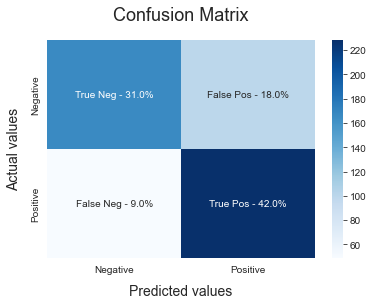

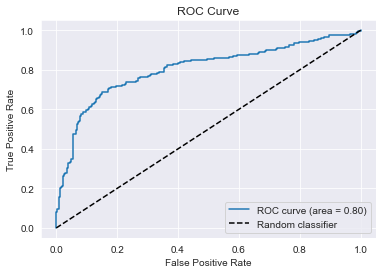

(0.7255985267034991, 0.7537190082644628, 0.8025569338508726)

In [21]:
# evaluating model

evaluate_model(model, Xdata, ydata)

## Conclusion

Based on the performance metrics provided for the logistic regression model, I can draw several conclusions about its effectiveness on the given dataset.

The model has an accuracy of approximately 72.56%. This means that about 72.56% of the predictions made by the model are correct.

The ROC AUC score is 0.80, which indicates good separability between the classes. A score closer to 1 would be ideal, but 0.80 still reflects a strong ability to distinguish between positive and negative sentiments.

The logistic regression model demonstrates reasonably good performance, with a balanced precision and recall, particularly excelling in identifying positive sentiments (class 1).

The higher recall for class 1 suggests that the model is good at capturing positive sentiments, though it may miss some negative sentiments (class 0) as indicated by its lower recall.

Given these metrics, the model can be considered effective for sentiment analysis.